# Text Classification on Lazada Product Review

In [89]:
import pandas as pd
import numpy as np
import re
import string
import itertools

from datetime import datetime
start_time = datetime.now()

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
%pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Note: you may need to restart the kernel to use updated packages.


In [70]:
#Collect Dataset
df = pd.read_csv(r"E:\Jupyter Notebook\orbit\nlp\text_classification\reviews.csv")
df.head()

,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,09 Apr 2019,androidApp,2019-10-02
1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24 Sep 2017,androidApp,2019-10-02
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood,0,0,0,True,21.50,04 Apr 2018,androidApp,2019-10-02
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22 Sep 2017,androidApp,2019-10-02
4,100002528,beli-harddisk-eksternal,Yosep M.,5,NaN,NaN,NaN,0,0,0,True,16.01,17 Agu 2018,androidApp,2019-10-02


In [71]:
#ambil kolom reviewContent dan rating
df = df[['reviewContent','rating']]
#Rename Column
df.rename(columns = {'reviewContent':'review','rating':'label'}, inplace=True)
df.head(10)

,review,label
0,bagus mantap dah sesui pesanan,5
1,"Bagus, sesuai foto",4
2,okkkkk mantaaaaaaapppp ... goood,5
3,bagus sesuai,4
4,NaN,5
5,NaN,5
6,NaN,5
7,bima,1
8,baru 10 bulan layarnya dah bergaris,1
9,"Pesan rabu sore,minggu sore sampe,,barang sesu...",5


In [72]:
# Data mempunyai 5 kelas, kita convert menjadi 3
def classes_def(x):
    if x ==  1:
        return "Negative"
    elif x == 2:
        return "Negative"
    elif x == 3:
        return "Positive"
    elif x ==  4:
        return "Positive"
    elif x == 5:
        return "Extremely Positive"

df['label']=df['label'].apply(lambda x:classes_def(x))

df.label.value_counts()

Extremely Positive    166016
Positive               24640
Negative               13131
Name: label, dtype: int64

# Exploratory Data Analysis (EDA)

Check for missing value

In [73]:
df.isna().sum()

review    96758
label         0
dtype: int64

Drop and check missing values


In [74]:
df = df.dropna(axis=0)
df.isna().sum()

review    0
label     0
dtype: int64

Check for duplicate reviews

In [75]:
dup_df = df[df['review'].duplicated()]
print(f'Number of duplicate reviews on dataset: {dup_df.shape[0]}')

Number of duplicate reviews on dataset: 68958


Check if the duplicate reviews have the same rating

In [76]:
dup_df['check'] = dup_df.apply(lambda x: str(x.review) + str(x.label), axis=1)
print(dup_df['check'].duplicated().sum(),'of duplicate reviews have the same label')

38848 of duplicate reviews have the same label


C:\Users\Acer\AppData\Local\Temp/ipykernel_15256/2452731918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup_df['check'] = dup_df.apply(lambda x: str(x.review) + str(x.label), axis=1)


Drop the duplicates

In [77]:
df.drop_duplicates(subset = 'review', inplace = True)

Label statistics

In [78]:
df['label'].value_counts()

Extremely Positive    29054
Positive               5571
Negative               3446
Name: label, dtype: int64

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'User Rating'}, xlabel='label', ylabel='count'>

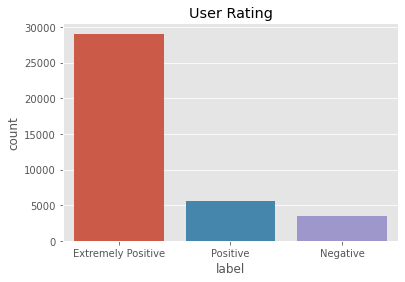

In [79]:
plt.title('User Rating')
sns.countplot(df.label)

Terlihat sangat jelas terdapat jumlah data yang tidak seimbang antara label Extremely Positive dengan label lain, sehingga kita coba untuk melakukan downsampling data menjadi sekitar 8000 untuk label Extremely Positive supaya data seimbang dan mengurangi training time

In [80]:
from sklearn.utils import resample
df_majority = df[df.label=='Extremely Positive']
df_other = df[df.label!='Extremely Positive']

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=8000,
                                   random_state=123)

df = pd.concat([df_majority_downsampled, df_other])

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'User Rating - Setelah downsampling'}, xlabel='label', ylabel='count'>

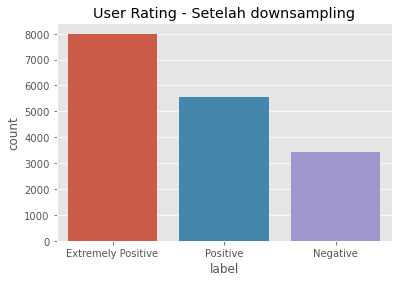

In [82]:
plt.title('User Rating - Setelah downsampling')
sns.countplot(df.label)

# Text Preprocessing

In [93]:
# Fungsi-fungsi preprocessing

def remove_repetitive_characters(text): # Menghapus huruf-huruf yang repetitive (berulang)
    return ''.join(''.join(s)[:1] for _, s in itertools.groupby(text))
    
def cleaningText(text):
    text = re.sub(r'(?<!\s)\.(?!\s)', ' ', text) # remove dots
    text = re.sub(r'(?<!\s)\,(?!\s)', ' ', text) # remove commas
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'#\w+','', text) # remove hash
    text = re.sub(r' +', ' ', text) # remove white space
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    text = text.split()
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    return " ".join(filtered)

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    return text

In [112]:
import requests
# Normalisasi Kata
url1 = (r'https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv')
url2 = (r'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
url3 = (r'https://raw.githubusercontent.com/okkyibrohim/id-abusive-language-detection/master/kamusalay.csv')
url4 = (r'https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt')
r = requests.get(url4)

kamus_normalisasi = pd.read_csv(url1)
kamus_alay1 = pd.read_csv(url2)
kamus_alay2 = pd.read_csv(url3, names=['slang','formal'])
kamus_slang = pd.json_normalize(r.json()).transpose().reset_index()
kamus_slang.columns = ['slang','formal']

def normalisasi(text):
  text = ' '.join([kamus_normalisasi[kamus_normalisasi['singkat'] == word]['hasil'].values[0] if (kamus_normalisasi['singkat'] == word).any() else word for word in text.split()])
  return text

def normalisasi_slang(text):
  text = ' '.join([kamus_alay1[kamus_alay1['slang'] == word]['formal'].values[0] if (kamus_alay1['slang'] == word).any() else word for word in text.split()])
  text = ' '.join([kamus_alay2[kamus_alay2['slang'] == word]['formal'].values[0] if (kamus_alay2['slang'] == word).any() else word for word in text.split()])
  text = ' '.join([kamus_slang[kamus_slang['slang'] == word]['formal'].values[0] if (kamus_slang['slang'] == word).any() else word for word in text.split()])
  return text

In [113]:
# Pipeline
def preprocessing(text):
  text = remove_repetitive_characters(text)
  text = cleaningText(text)
  text = casefoldingText(text)
  text = filteringText(text)
  text = stemmingText(text)
  text = normalisasi(text)
  text = normalisasi_slang(text)
  return text

In [114]:
# Start Preprocessing
df['clean'] = df['review'].apply(preprocessing)

end_time = datetime.now()
result_time = end_time-start_time
print("Duration:",result_time)

Duration: 4:12:41.353969


In [115]:
# Save hasil preprocessing
df.to_csv('review_preprocessed.csv')

# Word Cloud

Text(0.5, 1.0, 'Negative')

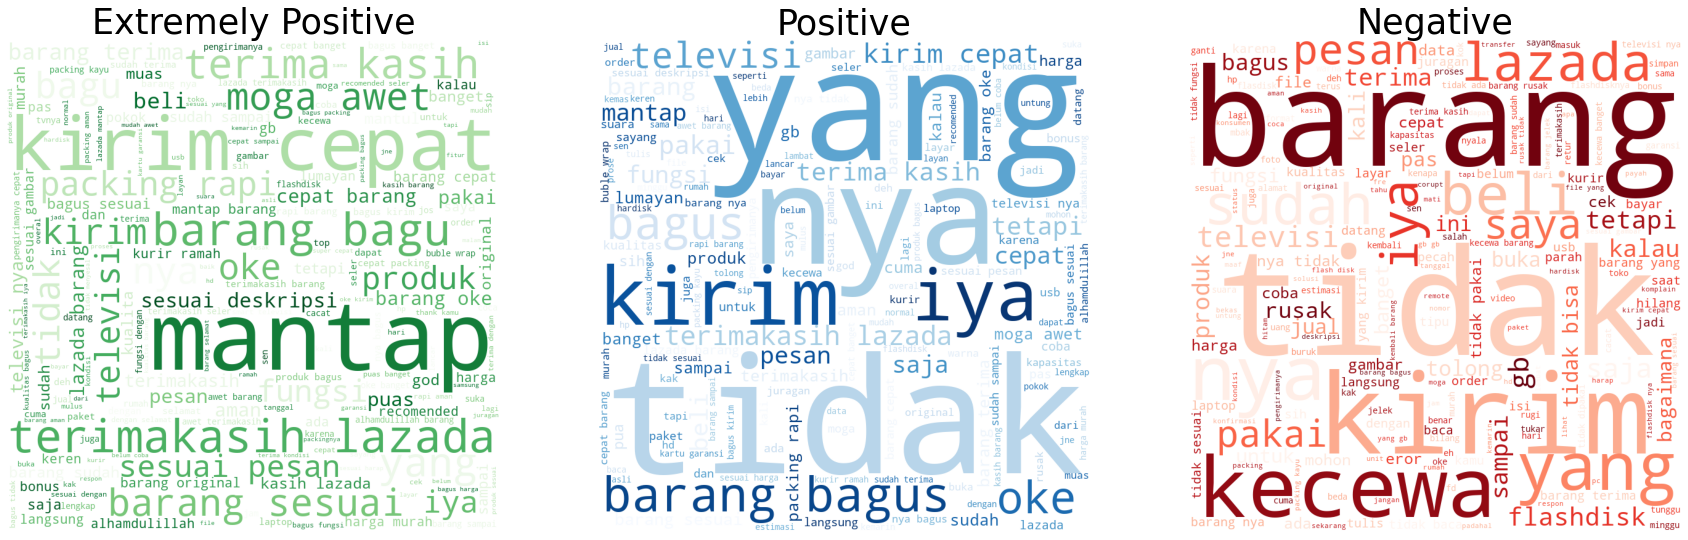

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_extpos = df[df["label"]=="Extremely Positive"]
df_pos = df[df["label"]=="Positive"]
df_neg = df[df["label"]=="Negative"]

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                min_font_size = 10).generate(" ".join(df_extpos.clean))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Extremely Positive', fontsize=35)

wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Blues",
                min_font_size = 10).generate(" ".join(df_pos.clean))

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Positive', fontsize=35)

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                min_font_size = 10).generate(" ".join(df_neg.clean))

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Negative', fontsize=35)

# Vectorization

In [117]:
#Bag of Word (BoW)
x = df['clean']
y = df['label']

print(len(x), len(y))

17017 17017


In [182]:
# Inisiasi vectorizer
vect = CountVectorizer(ngram_range=(1,2), max_features=10000)
vect.fit_transform(x.values.astype('U'))

# mmebuat document-term matrix dari train dan test sets
x_dtm = vect.transform(x.values.astype('U')).toarray()
x_dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## TF-IDF

In [183]:
# Inisiasi TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_dtm)

x_tfidf = tfidf_transformer.transform(x_dtm).toarray()

df_tfidf = pd.DataFrame(x_tfidf, columns = vect.get_feature_names())
df_tfidf

,abal,abal abal,abang,abang kurir,ac,acara,aceh,acer,aces,ada,...,yang tidak,yang tulis,yang warna,yang yang,yasudahlah,youtube,youtube lancar,youtube oke,yutub,zenfone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [184]:
x_array = np.array(df_tfidf)
y_array = np.array(y)

In [185]:
chi2_features= SelectKBest(chi2, k = 5000) 
X_kbest_features = chi2_features.fit_transform(x_array, y_array) 

print('Original feature number:', x_array.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 10000
Reduced feature number: 5000


In [186]:
# Data nilai chi2
data = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data.head()

,nilai
0,23.692788
1,3.653416
2,1.269904
3,1.325564
4,0.092458


In [187]:
# Data fitur dengan nilainya
feature = vect.get_feature_names()

data['Fitur'] = feature
data.head(10)

,nilai,Fitur
0,23.692788,abal
1,3.653416,abal abal
2,1.269904,abang
3,1.325564,abang kurir
4,0.092458,ac
5,0.319317,acara
6,1.028091,aceh
7,0.944118,acer
8,0.351827,aces
9,11.749716,ada


In [188]:
# Mengurutkan fitur berdasarkan nilai chi2 terbaik
data.sort_values(by='nilai', ascending=False)

,nilai,Fitur
4208,234.199742,kecewa
9194,206.686904,tidak
7225,194.667789,rusak
5161,179.605095,mantap
2633,130.770093,file
...,...,...
5085,0.000199,lumayan terimakasih
731,0.000199,barang kartu
4017,0.000197,kali sen
793,0.000125,barang real


In [189]:
mask = chi2_features.get_support()
mask

array([ True,  True,  True, ..., False,  True, False])

In [190]:
#Menampilkan fitur-fitur terpilih berdasarkan nilai mask atau nila tertinggi yang sudah ditetapkan pada Chi-Square
new_feature=[]
for bool,f in zip(mask,feature):
    if bool:
        new_feature.append(f)
    selected_feature = new_feature

In [191]:
data_selected_feature = pd.DataFrame(X_kbest_features,columns=selected_feature)
data_selected_feature

,abal,abal abal,abang,abang kurir,ada,ada baik,ada barang,ada buka,ada cek,ada coba,...,yang sesuai,yang simpan,yang sudah,yang tercopy,yang terima,yang tidak,yang warna,yang yang,yasudahlah,yutub
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Text Classification

In [192]:
X = data_selected_feature
y = df.label

# Split data ke dalam train dan test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
print("Train Sets Size: ", len(x_train))
print("Test Sets Size: ", len(x_test))

Train Sets Size:  11911
Test Sets Size:  5106


In [193]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),
    LogisticRegression(max_iter=1000),
    SGDClassifier(loss='modified_huber',max_iter=1000,tol=1e-3,n_iter_no_change=10,early_stopping=True, n_jobs=-1)
]

In [194]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [195]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc.sort_values(by='Mean Accuracy', ascending=False)

,Mean Accuracy,Standard deviation
model_name,,
LogisticRegression,0.672906,0.010252
MultinomialNB,0.667030,0.010187
LinearSVC,0.661321,0.011001
SGDClassifier,0.643270,0.013872
KNeighborsClassifier,0.476785,0.008986
RandomForestClassifier,0.470909,0.001832


Seperti yang terlihat di tabel di atas, model Logistic Regression memiliki akurasi tertinggi yaitu 67%, diikuti oleh Multinomial Naïve Bayes, LinearSVC, Stochastic Gradient Descent, KNN, dan Random Forest. 

In [196]:
# Modeling menggunakan Linear SVC
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [197]:
# Save model
from joblib import dump
dump(model, filename="model_sentiment_LogReg_unibi.joblib")

['model_sentiment_LogReg_unibi.joblib']

In [198]:
# Classification Report
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Extremely Positive       0.70      0.83      0.76      2437
          Negative       0.76      0.72      0.74      1035
          Positive       0.57      0.44      0.50      1634

          accuracy                           0.68      5106
         macro avg       0.68      0.66      0.67      5106
      weighted avg       0.67      0.68      0.67      5106



## Confusion Matrix

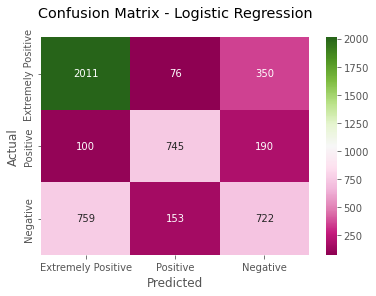

In [202]:
ax= plt.subplot()

CM = confusion_matrix(y_test, y_pred)

sns.heatmap(CM, annot=True, cmap="PiYG",fmt='g', ax=ax)

ax.set_xlabel('Predicted');
ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix - Logistic Regression', pad=20); 
ax.xaxis.set_ticklabels(['Extremely Positive','Positive','Negative']);
ax.yaxis.set_ticklabels(['Extremely Positive','Positive','Negative']);

# Classification Predictor

In [203]:
from joblib import load

pipeline = load("model_sentiment_LogReg.joblib")
data_input = input("Masukkan review:\n")

review = preprocessing(data_input)
tfidf = TfidfVectorizer

loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(data_selected_feature))
hasil = pipeline.predict(loaded_vec.fit_transform([review]))

print(f"Review pembeli:\n {data_input}")
print("Hasil prediksi:\n", hasil)

Review pembeli:
 untuk kualitas produk cukup baik sebanding dengan harganya, penjual ramah dan fast respon, recommended untuk dibeli, mantap dah
Hasil prediksi:
 ['Extremely Positive']
